# Calibrate all snapshots (BTC and ETH)

This notebook:

1. Loads every `deribit_options_snapshot_*.csv` file from `data/`.
2. Applies a **global** liquidity filter (`src.calibration.filter_liquid_options`) and a **global** weighting scheme (`src.calibration.WeightConfig`).
3. For each snapshot and for each currency (BTC then ETH):
   - draws a random **70/30 train/test split**,
   - calibrates **Black**, **Heston**, and **SVCJ** on the training set using **price-based** weighted least squares (`src.calibration.calibrate_model`),
   - reprices train and test options (`src.calibration.price_dataframe`),
   - computes train/test **MSE** and **MAE** in coin units.
4. Plots time series of train/test MSE and MAE for each model.
5. Plots time series of the calibrated parameters (one subplot per model).

In [1]:
# Imports and project path setup
from __future__ import annotations

import sys
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from IPython.display import display

import os
import contextlib
from typing import Optional

try:
    from threadpoolctl import threadpool_limits
except Exception:
    threadpool_limits = None


# --- locate project root (folder that contains `src/` and `data/`)
ROOT = Path.cwd().resolve()
if not (ROOT / "src").exists() and (ROOT.parent / "src").exists():
    ROOT = ROOT.parent.resolve()

assert (ROOT / "src").exists(), f"Could not find src/ from cwd={Path.cwd()}"
assert (ROOT / "data").exists(), f"Could not find data/ from cwd={Path.cwd()}"

# Make project importable
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src.calibration import (
    filter_liquid_options,
    calibrate_model,
    price_dataframe,
    WeightConfig,
)
from src.inverse_fft_pricer import FFTParams

pd.set_option("display.max_columns", 200)

## Global configuration

In [2]:
# -----------------------------
# Global filter rules (liquidity cleaning)
# -----------------------------
FILTER_RULES = dict(
    require_bid_ask=True,             # drop rows missing bid OR ask (hard requirement)
    min_time_to_maturity=1/365,
    max_time_to_maturity=None,
    min_open_interest=1.0,
    min_vega=0.0,
    max_rel_spread=0.50,              # relative spread cap (ask-bid)/mid
    moneyness_range=(0.5, 2.0),       # K/F0 range
    drop_synthetic_underlyings=False, # optionally drop SYN.* futures underlyings
)


# -----------------------------
# Parallelism (per-snapshot processing)
# -----------------------------
N_THREADS = int(os.cpu_count() - 2)  # max worker threads used in run_all_snapshots_for_currency

# Prevent oversubscription: each worker may call heavy NumPy/SciPy/FFT kernels.
# Limiting internal threadpools often improves throughput when N_THREADS > 1.
LIMIT_INTERNAL_THREADS = True
INTERNAL_NUM_THREADS = 1  # set to 1 (recommended) unless you know you want more

# -----------------------------
# Global weight config (used in calibration residuals)
# r_i = w_i * (P_model_i - P_mkt_i)
# -----------------------------
WEIGHT_CONFIG = WeightConfig(
    use_spread=True,
    use_vega=False, # was true
    use_open_interest=False, # was true
    spread_power=1.0,
    vega_power=0.5,
    oi_power=0.5,
    eps_spread=1e-6,
    eps_other=1e-12,
    cap=1e6,
)

# -----------------------------
# Carr–Madan FFT base parameters
# (dynamic_b=True will recenter b per expiry group; N/eta/alpha come from here)
# -----------------------------
FFT_BASE = FFTParams(
    N=2**12,
    eta=0.10,
    alpha=1.5,
    b=-10.0,          # ignored when dynamic_b=True; kept for completeness
    use_simpson=True,
)

# -----------------------------
# Calibration knobs
# -----------------------------
TRAIN_FRAC = 0.70
GLOBAL_RANDOM_SEED = 123

# max_nfev is the main runtime control (per model per snapshot)
MAX_NFEV = dict(
    black=200,
    heston=200,
    svcj=200,
)

# -----------------------------
# Runtime guards (recommended when looping many snapshots)
# -----------------------------
RUNTIME_TOP_EXPIRIES_BY_OI = None     # keep only top expiries by total OI per snapshot/currency
RUNTIME_MAX_OPTIONS = None         # cap number of options per snapshot/currency after filtering

## Helper utilities

In [3]:
def list_snapshot_files(data_dir: Path) -> list[Path]:
    files = sorted(data_dir.glob("deribit_options_snapshot_*.csv"))
    # Drop macOS metadata files if present
    files = [f for f in files if not f.name.startswith("._")]
    return files

_TS_RE = re.compile(r"deribit_options_snapshot_(\d{8}T\d{6})Z\.csv$")

def timestamp_from_filename(path: Path) -> pd.Timestamp:
    m = _TS_RE.search(path.name)
    if not m:
        raise ValueError(f"Cannot parse timestamp from filename: {path.name}")
    return pd.to_datetime(m.group(1), format="%Y%m%dT%H%M%S", utc=True)

def restrict_for_runtime(df: pd.DataFrame, *, top_expiries: int, max_options: int, random_state: int) -> pd.DataFrame:
    """Optional additional selection to keep the per-snapshot calibration runtime under control."""
    out = df.copy()

    if top_expiries is not None and top_expiries > 0:
        oi_by_expiry = out.groupby("expiry_datetime")["open_interest"].sum().sort_values(ascending=False)
        keep_expiries = oi_by_expiry.head(top_expiries).index
        out = out[out["expiry_datetime"].isin(keep_expiries)].copy()

    if max_options is not None and len(out) > max_options:
        out = out.sample(n=max_options, random_state=random_state).copy()

    return out.reset_index(drop=True)

def train_test_split_df(df: pd.DataFrame, train_frac: float, random_state: int) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_shuffled = df.sample(frac=1.0, random_state=random_state).reset_index(drop=True)
    n_train = int(np.floor(train_frac * len(df_shuffled)))
    train = df_shuffled.iloc[:n_train].copy()
    test = df_shuffled.iloc[n_train:].copy()
    return train, test

def compute_errors(y_true: np.ndarray, y_pred: np.ndarray, *, min_finite_frac: float = 0.8) -> dict[str, float]:
    """Compute MSE/MAE, guarding against occasional non-finite model outputs during calibration.

    If too many predictions are non-finite, returns NaN metrics (so plots show gaps).
    """
    finite = np.isfinite(y_pred)
    if finite.sum() == 0:
        return {"mse": float("nan"), "mae": float("nan")}
    if finite.mean() < min_finite_frac:
        return {"mse": float("nan"), "mae": float("nan")}

    err = y_pred[finite] - y_true[finite]
    mse = float(np.mean(err**2))
    mae = float(np.mean(np.abs(err)))
    return {"mse": mse, "mae": mae}

def show_filtered_preview(df_filt: pd.DataFrame, n: int = 10) -> None:
    display_cols = [
        "currency", "instrument_name", "option_type", "expiry_datetime",
        "strike", "F0", "time_to_maturity",
        "bid_price", "ask_price", "mid_price_clean",
        "spread", "rel_spread", "vega", "open_interest",
        "moneyness",
    ]
    cols = [c for c in display_cols if c in df_filt.columns]
    display(df_filt[cols].head(n))

## Core routine: process one snapshot and one currency

In [4]:
def process_snapshot(
    csv_path: Path,
    *,
    currency: str,
    filter_rules: dict,
    weight_config: WeightConfig,
    fft_base: FFTParams,
    max_nfev: dict,
    train_frac: float,
    random_seed: int,
    runtime_top_expiries_by_oi: int,
    runtime_max_options: int,
    warm_start: Optional[dict[str, dict[str, float]]] = None,
    verbose: bool = False,
) -> tuple[pd.DataFrame, dict[str, dict[str, float]]]:
    """Process one snapshot CSV: filter, split, calibrate models, and compute train/test errors.

    Parameters
    ----------
    warm_start:
        Optional dict of previous fitted params, e.g. {'black': {...}, 'heston': {...}, 'svcj': {...}}.
        Used only as initial guesses; does not change the objective or pricing logic.
    """
    ts = timestamp_from_filename(csv_path)
    df_raw = pd.read_csv(csv_path)

    # Filter to liquid options (computes mid_price_clean/spread/F0/moneyness/...)
    df_filt = filter_liquid_options(df_raw, currency=currency, **filter_rules)
    if len(df_filt) < 30:
        if verbose:
            print(f"[{currency}] {csv_path.name}: too few options after filtering: {len(df_filt)}")
        return pd.DataFrame(), {}

    # Optional runtime restriction (top expiries + cap option count)
    df_filt = restrict_for_runtime(
        df_filt,
        top_expiries=runtime_top_expiries_by_oi,
        max_options=runtime_max_options,
        random_state=random_seed,
    )

    # --- Precompute per-expiry FFTParams using *all* filtered options in this snapshot.
    # This keeps FFT grids stable across train/test splits and reduces redundant FFT work.
    def _fft_params_for_expiry(strikes: np.ndarray) -> FFTParams:
        N = fft_base.N
        eta = fft_base.eta
        lam = 2.0 * np.pi / (N * eta)
        logK_center = float(np.log(np.median(strikes)))
        b = logK_center - 0.5 * N * lam
        return FFTParams(N=N, alpha=fft_base.alpha, eta=eta, b=b, use_simpson=fft_base.use_simpson)

    fft_params_by_expiry: dict = {}
    for exp, g in df_filt.groupby("expiry_datetime", sort=False):
        K_all = g["strike"].to_numpy(dtype=float)
        fft_params_by_expiry[exp] = _fft_params_for_expiry(K_all)

    # Train/test split
    train, test = train_test_split_df(df_filt, train_frac=train_frac, random_state=random_seed)

    # Warm-start helpers
    warm_start = warm_start or {}
    init_black = warm_start.get("black", None)

    def _init_heston_from_black(sigma: float, prev: Optional[dict[str, float]]) -> dict[str, float]:
        sigma2 = float(sigma) * float(sigma)
        init = dict(prev) if prev else {}
        init.setdefault("kappa", 2.0)
        init.setdefault("sigma_v", 0.8)
        init.setdefault("rho", -0.5)
        init["theta"] = sigma2
        init["v0"] = sigma2
        return init

    def _init_svcj_from_black(sigma: float, prev: Optional[dict[str, float]]) -> dict[str, float]:
        sigma2 = float(sigma) * float(sigma)
        init = dict(prev) if prev else {}
        init.setdefault("kappa", 2.0)
        init.setdefault("sigma_v", 0.8)
        init.setdefault("rho", -0.5)
        init["theta"] = sigma2
        init["v0"] = sigma2
        init.setdefault("lam", 0.2)
        init.setdefault("ell_y", -0.05)
        init.setdefault("sigma_y", 0.25)
        init.setdefault("ell_v", 0.1)
        init.setdefault("rho_j", 0.0)
        return init

    # Calibrate + reprice
    models = ["black", "heston", "svcj"]
    params_by_model: dict[str, dict[str, float]] = {}
    rows = []

    sigma_seed = None  # updated after Black calibration

    for model in models:
        if verbose:
            print(f"[{currency}] {ts} | {model}: calibrating on n_train={len(train)}")

        if model == "black":
            init_params = init_black
        elif model == "heston":
            if sigma_seed is None:
                # fallback if black not run (shouldn't happen)
                sigma_seed = float(init_black.get("sigma", 0.6)) if init_black else 0.6
            init_params = _init_heston_from_black(sigma_seed, warm_start.get("heston", None))
        else:  # svcj
            if sigma_seed is None:
                sigma_seed = float(init_black.get("sigma", 0.6)) if init_black else 0.6
            init_params = _init_svcj_from_black(sigma_seed, warm_start.get("svcj", None))

        res = calibrate_model(
            train,
            model,
            weight_config=weight_config,
            fft_params_base=fft_base,
            dynamic_b=False,  # use fixed per-expiry FFTParams from full snapshot
            fft_params_by_expiry=fft_params_by_expiry,
            initial_params=init_params,
            max_nfev=int(max_nfev[model]),
            verbose=0 if not verbose else 1,
            clear_cache_before=False,  # avoid global cache clearing in threaded runs
            use_cache_in_optimization=False,  # bypass FFT cache during optimization
        )
        params_by_model[model] = dict(res.params)

        if model == "black":
            # update sigma seed for subsequent models
            sig = float(res.params.get("sigma", np.nan))
            sigma_seed = sig if np.isfinite(sig) else (float(init_black.get("sigma", 0.6)) if init_black else 0.6)

        # Reprice (train/test) using the *same* per-expiry FFTParams
        y_train = train["mid_price_clean"].to_numpy()
        y_test = test["mid_price_clean"].to_numpy()

        p_train = price_dataframe(
            train,
            model,
            res.params,
            fft_params_base=fft_base,
            dynamic_b=False,
            fft_params_by_expiry=fft_params_by_expiry,
            use_cache=True,
        )
        p_test = price_dataframe(
            test,
            model,
            res.params,
            fft_params_base=fft_base,
            dynamic_b=False,
            fft_params_by_expiry=fft_params_by_expiry,
            use_cache=True,
        )

        e_train = compute_errors(y_train, p_train)
        e_test = compute_errors(y_test, p_test)

        rows.append(
            {
                "timestamp": ts,
                "currency": currency,
                "model": model,
                "split": "train",
                "mse": e_train["mse"],
                "mae": e_train["mae"],
                "n_options": int(len(train)),
            }
        )
        rows.append(
            {
                "timestamp": ts,
                "currency": currency,
                "model": model,
                "split": "test",
                "mse": e_test["mse"],
                "mae": e_test["mae"],
                "n_options": int(len(test)),
            }
        )

    metrics_df = pd.DataFrame(rows).sort_values(["timestamp", "model", "split"]).reset_index(drop=True)
    return metrics_df, params_by_model

## Runner: loop all snapshots for one currency

In [5]:
def run_all_snapshots_for_currency(currency: str, *, verbose: bool = False):
    files = list_snapshot_files(ROOT / "data")
    if len(files) == 0:
        raise RuntimeError(f"No snapshot CSVs found in {ROOT/'data'}")

    n_workers = max(1, min(int(N_THREADS), len(files)))

    all_metrics = []
    # params_timeseries[model][timestamp] = params dict
    params_timeseries: dict[str, dict[pd.Timestamp, dict[str, float]]] = {"black": {}, "heston": {}, "svcj": {}}

    def _make_chunks(seq: list[Path], k: int) -> list[tuple[int, list[Path]]]:
        """Contiguous chunks (preserves time ordering within each worker for warm-start)."""
        n = len(seq)
        chunks: list[tuple[int, list[Path]]] = []
        for w in range(k):
            start = (w * n) // k
            end = ((w + 1) * n) // k
            if start < end:
                chunks.append((start, seq[start:end]))
        return chunks

    chunks = _make_chunks(files, n_workers)

    def _run_chunk(start_idx: int, chunk_files: list[Path]):
        results = []
        warm: Optional[dict[str, dict[str, float]]] = None

        ctx = contextlib.nullcontext()
        if LIMIT_INTERNAL_THREADS and (threadpool_limits is not None):
            ctx = threadpool_limits(limits=int(INTERNAL_NUM_THREADS))

        with ctx:
            for j, f in enumerate(chunk_files):
                i = start_idx + j
                ts = timestamp_from_filename(f)
                seed = GLOBAL_RANDOM_SEED + i  # deterministic per snapshot

                metrics_df, params_by_model = process_snapshot(
                    f,
                    currency=currency,
                    filter_rules=FILTER_RULES,
                    weight_config=WEIGHT_CONFIG,
                    fft_base=FFT_BASE,
                    max_nfev=MAX_NFEV,
                    train_frac=TRAIN_FRAC,
                    random_seed=seed,
                    runtime_top_expiries_by_oi=RUNTIME_TOP_EXPIRIES_BY_OI,
                    runtime_max_options=RUNTIME_MAX_OPTIONS,
                    warm_start=warm,
                    verbose=verbose,
                )

                if not metrics_df.empty:
                    results.append((ts, metrics_df, params_by_model))
                    warm = params_by_model  # warm-start next snapshot in this chunk

        return results

    # --- Run chunks (parallel over chunks; sequential within each chunk for warm-start)
    chunk_results = []
    if len(chunks) == 1:
        chunk_results = _run_chunk(chunks[0][0], chunks[0][1])
    else:
        with ThreadPoolExecutor(max_workers=len(chunks)) as ex:
            futs = [ex.submit(_run_chunk, start, ch) for start, ch in chunks]
            for fut in futs:
                try:
                    chunk_results.extend(fut.result())
                except Exception as e:
                    raise RuntimeError(f"Snapshot chunk failed for currency={currency}") from e

    for ts, metrics_df, params_by_model in chunk_results:
        if metrics_df.empty:
            continue
        all_metrics.append(metrics_df)
        for model, params in params_by_model.items():
            params_timeseries[model][ts] = params

    if len(all_metrics) == 0:
        raise RuntimeError(f"No usable snapshots produced metrics for currency={currency}")

    metrics = pd.concat(all_metrics, ignore_index=True)
    metrics = metrics.sort_values(["timestamp", "model", "split"]).reset_index(drop=True)

    return metrics, params_timeseries

## Plotting helpers

In [6]:
def plot_metric_timeseries(metrics: pd.DataFrame, *, currency: str, metric: str):
    assert metric in {"mse", "mae"}
    models = ["black", "heston", "svcj"]

    fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True)
    fig.suptitle(f"{currency}: {metric.upper()} over time (train vs test)")

    for ax, split in zip(axes, ["train", "test"]):
        sub = metrics[metrics["split"] == split]
        for model in models:
            s = sub[sub["model"] == model].sort_values("timestamp")
            ax.plot(s["timestamp"], s[metric], marker="o", label=model)
        ax.set_ylabel(f"{split} {metric.upper()} (coin^2)" if metric == "mse" else f"{split} {metric.upper()} (coin)")
        ax.grid(True, alpha=0.3)
        ax.legend()

    axes[-1].set_xlabel("Snapshot time (UTC)")
    plt.tight_layout()
    plt.show()

def params_dict_to_frame(params_timeseries_model: dict[pd.Timestamp, dict[str, float]]) -> pd.DataFrame:
    if not params_timeseries_model:
        return pd.DataFrame()
    # union of param keys
    keys = sorted({k for d in params_timeseries_model.values() for k in d.keys()})
    idx = sorted(params_timeseries_model.keys())
    data = {k: [] for k in keys}
    for ts in idx:
        d = params_timeseries_model[ts]
        for k in keys:
            data[k].append(d.get(k, np.nan))
    out = pd.DataFrame(data, index=pd.to_datetime(idx)).sort_index()
    out.index.name = "timestamp"
    return out

def plot_params_timeseries(params_timeseries: dict[str, dict[pd.Timestamp, dict[str, float]]], *, currency: str):
    models = ["black", "heston", "svcj"]
    fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
    fig.suptitle(f"{currency}: calibrated parameter time series")

    for ax, model in zip(axes, models):
        dfp = params_dict_to_frame(params_timeseries[model])
        if dfp.empty:
            ax.set_title(f"{model}: (no params)")
            continue

        for col in dfp.columns:
            ax.plot(dfp.index, dfp[col], marker="o", label=col)

        ax.set_title(model)
        ax.grid(True, alpha=0.3)
        ax.legend(ncol=3, fontsize=9)

    axes[-1].set_xlabel("Snapshot time (UTC)")
    plt.tight_layout()
    plt.show()

## Run everything: BTC then ETH

[BTC] 2025-12-31 09:18:28+00:00 | black: calibrating on n_train=273[BTC] 2026-01-01 09:18:35+00:00 | black: calibrating on n_train=240

[BTC] 2026-01-02 09:18:09+00:00 | black: calibrating on n_train=275
[BTC] 2025-12-30 21:17:51+00:00 | black: calibrating on n_train=274
[BTC] 2025-12-30 17:31:15+00:00 | black: calibrating on n_train=278
[BTC] 2026-01-01 21:19:18+00:00 | black: calibrating on n_train=264
`ftol` termination condition is satisfied.
Function evaluations 4, initial cost 3.1161e+03, final cost 3.1139e+03, first-order optimality 2.78e-01.
[BTC] 2025-12-31 09:18:28+00:00 | heston: calibrating on n_train=273
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 2.2436e+03, final cost 2.1841e+03, first-order optimality 1.35e-02.
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 2.7442e+03, final cost 2.6343e+03, first-order optimality 7.96e-03.
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost

,timestamp,currency,model,split,mse,mae,n_options
0,2025-12-30 17:31:15+00:00,BTC,black,test,0.000025,0.003629,120
1,2025-12-30 17:31:15+00:00,BTC,black,train,0.000034,0.003963,278
2,2025-12-30 17:31:15+00:00,BTC,heston,test,0.000002,0.001009,120
3,2025-12-30 17:31:15+00:00,BTC,heston,train,0.000006,0.001201,278
4,2025-12-30 17:31:15+00:00,BTC,svcj,test,0.000002,0.000503,120
5,2025-12-30 17:31:15+00:00,BTC,svcj,train,0.000004,0.000700,278
6,2025-12-30 21:17:51+00:00,BTC,black,test,0.000040,0.003966,118
7,2025-12-30 21:17:51+00:00,BTC,black,train,0.000036,0.004278,274
8,2025-12-30 21:17:51+00:00,BTC,heston,test,0.000010,0.001262,118
9,2025-12-30 21:17:51+00:00,BTC,heston,train,0.000007,0.001377,274


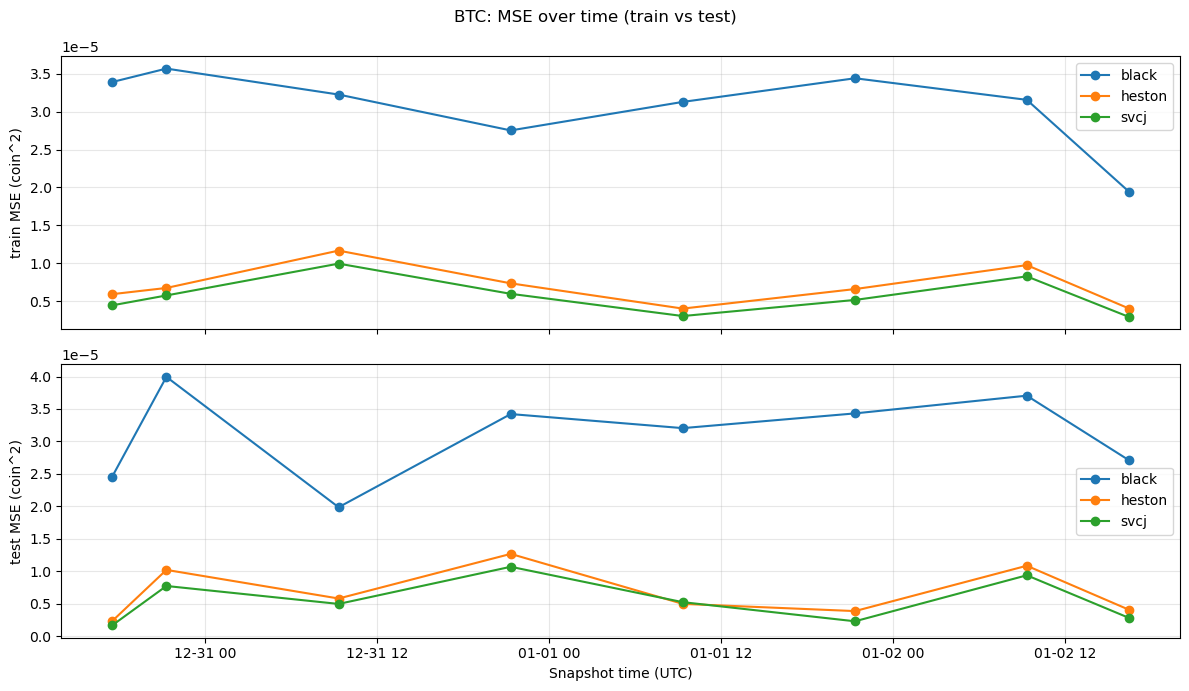

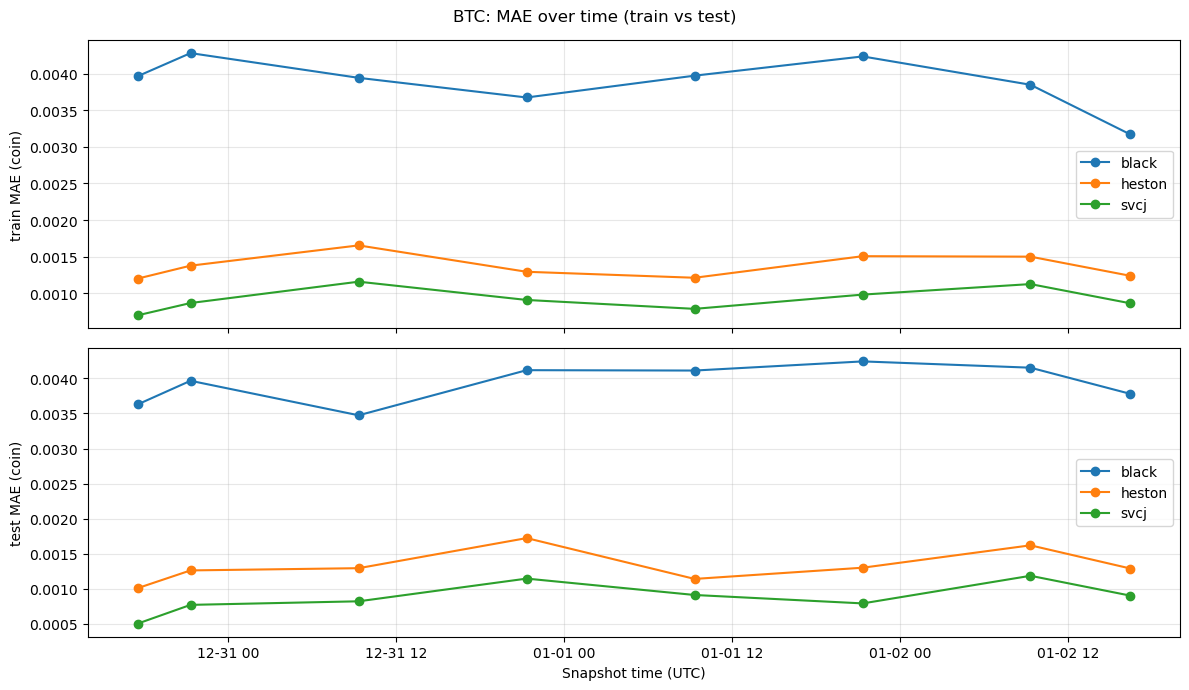

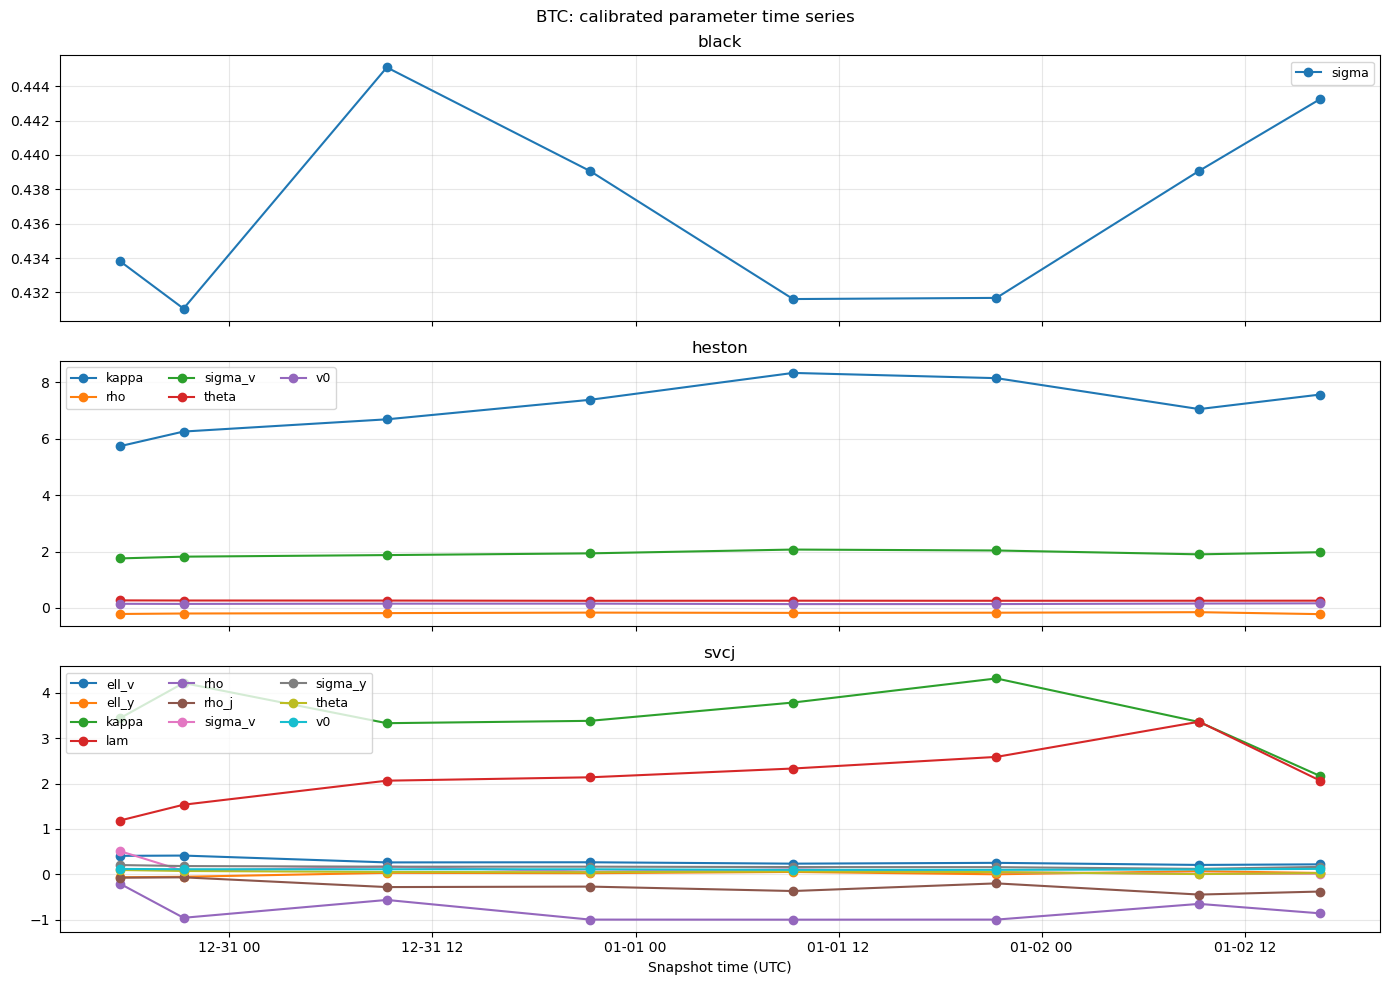

[ETH] 2025-12-30 21:17:51+00:00 | black: calibrating on n_train=277
[ETH] 2026-01-01 09:18:35+00:00 | black: calibrating on n_train=267
[ETH] 2026-01-01 21:19:18+00:00 | black: calibrating on n_train=273
[ETH] 2025-12-30 17:31:15+00:00 | black: calibrating on n_train=282
[ETH] 2025-12-31 09:18:28+00:00 | black: calibrating on n_train=274
[ETH] 2026-01-02 09:18:09+00:00 | black: calibrating on n_train=284
`ftol` termination condition is satisfied.
Function evaluations 4, initial cost 2.1345e+03, final cost 2.0987e+03, first-order optimality 2.45e-01.
`ftol` termination condition is satisfied.
Function evaluations 4, initial cost 1.7009e+03, final cost 1.6159e+03, first-order optimality 6.46e-01.
[ETH] 2025-12-30 21:17:51+00:00 | heston: calibrating on n_train=277
[ETH] 2025-12-30 17:31:15+00:00 | heston: calibrating on n_train=282
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 3.1016e+03, final cost 2.8975e+03, first-order optimality 3.89e-02.
`ftol` ter

,timestamp,currency,model,split,mse,mae,n_options
0,2025-12-30 17:31:15+00:00,ETH,black,test,0.000033,0.004367,122
1,2025-12-30 17:31:15+00:00,ETH,black,train,0.000042,0.004851,282
2,2025-12-30 17:31:15+00:00,ETH,heston,test,0.000009,0.001514,122
3,2025-12-30 17:31:15+00:00,ETH,heston,train,0.000014,0.001920,282
4,2025-12-30 17:31:15+00:00,ETH,svcj,test,0.000008,0.001124,122
5,2025-12-30 17:31:15+00:00,ETH,svcj,train,0.000012,0.001566,282
6,2025-12-30 21:17:51+00:00,ETH,black,test,0.000028,0.004020,120
7,2025-12-30 21:17:51+00:00,ETH,black,train,0.000053,0.005339,277
8,2025-12-30 21:17:51+00:00,ETH,heston,test,0.000005,0.001295,120
9,2025-12-30 21:17:51+00:00,ETH,heston,train,0.000019,0.002111,277


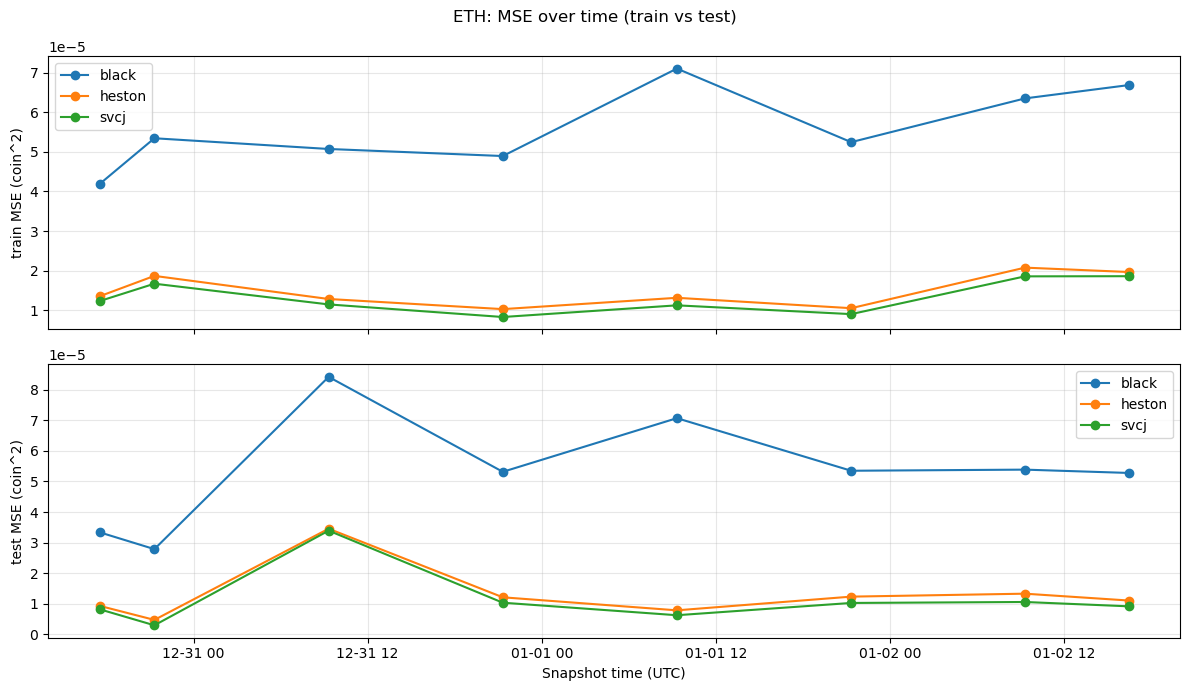

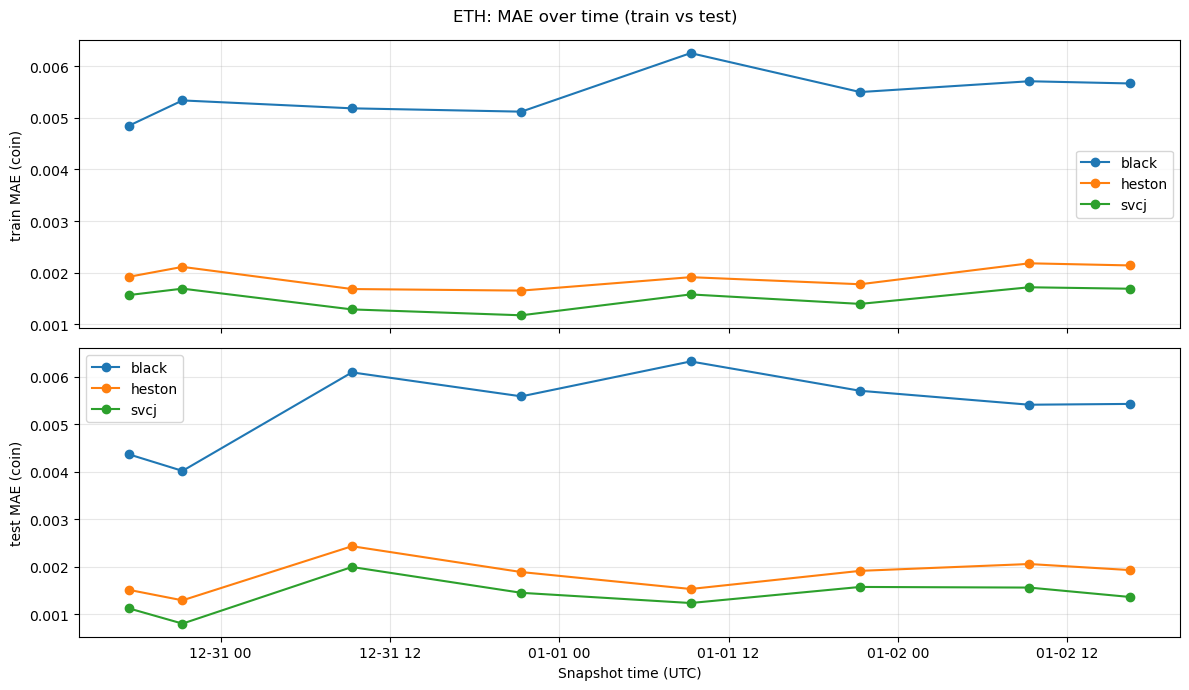

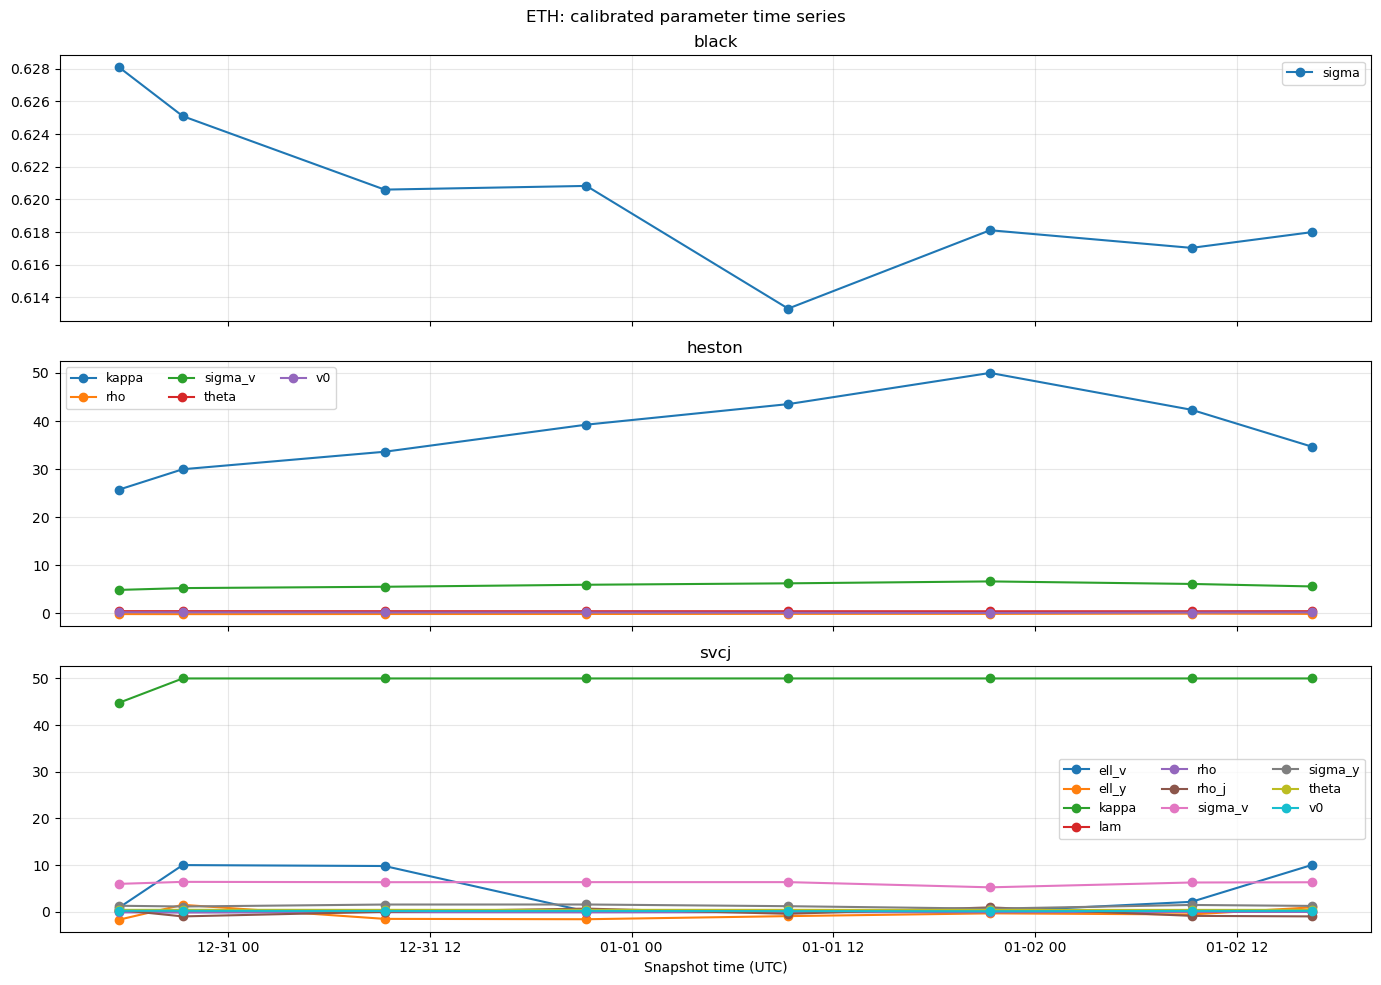

In [7]:
# ---- BTC
btc_metrics, btc_params = run_all_snapshots_for_currency("BTC", verbose=True)

display(btc_metrics.head(12))
plot_metric_timeseries(btc_metrics, currency="BTC", metric="mse")
plot_metric_timeseries(btc_metrics, currency="BTC", metric="mae")
plot_params_timeseries(btc_params, currency="BTC")

# ---- ETH
eth_metrics, eth_params = run_all_snapshots_for_currency("ETH", verbose=True)

display(eth_metrics.head(12))
plot_metric_timeseries(eth_metrics, currency="ETH", metric="mse")
plot_metric_timeseries(eth_metrics, currency="ETH", metric="mae")
plot_params_timeseries(eth_params, currency="ETH")